## import

In [11]:
import torch
import torch.nn as nn  # Import neural network module
import torch.optim as optim  # Import optimization module
from torchvision import datasets, transforms  # Import for datasets and transformations

In [10]:
# 디바이스 설정 (GPU 우선)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Data preparation

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean 0.5 and standard deviation 0.5
])

## Load MNIST datasets, applying the defined transformations

In [12]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [13]:
type(train_dataset), type(valid_dataset)

(torchvision.datasets.mnist.MNIST, torchvision.datasets.mnist.MNIST)

In [14]:
train_dataset.data.shape, valid_dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [15]:
train_dataset.targets.shape, valid_dataset.targets.shape

(torch.Size([60000]), torch.Size([10000]))

## Create DataLoaders for efficient training and testing data handling

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [8]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [15]:
X, Y = next(iter(train_loader))
X.shape, Y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

## Model definition

In [17]:
model = nn.Sequential(
    nn.Flatten(),     # Flatten images into a single vector
    nn.Linear(784, 128),  # Fully connected layer with 128 neurons
    nn.ReLU(),           # ReLU activation for non-linearity
    nn.Linear(128, 10)   # Output layer with 10 neurons (for 10 classes in MNIST)
)

## Loss function and optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss()  # Common loss function for classification
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent optimizer

## Training and Evaluation loop

In [19]:
len(valid_loader.dataset), len(train_loader.dataset)

(10000, 60000)

In [ ]:
len(train_loader), len(valid_loader)

(938, 157)

In [20]:
train_loader.batch_size, valid_loader.batch_size

(64, 64)

In [36]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 3
total_num_dataset = len(train_loader.dataset)  # 전체 train_dataset(60000)
num_batches_per_epoch = len(train_loader)  # 전체 train_dataset(60000) / batch_size=64 -> 938
print(f"Total batches per epoch: {num_batches_per_epoch}")

for epoch in range(num_epochs):  # Loop for 5 epochs
    # Epoch 변화 출력
    print(f"\nEpoch {epoch + 1}/{num_epochs}")  
    
    ## Train
    model.train()  # Set the model to training mode
    
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # 데이터를 GPU로 이동
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)   # target.size(0) -> batch_szie
    
    print(f'{batch_idx+1}/{len(train_loader)}')
    print('total', total)

    train_loss = train_loss / num_batches_per_epoch  # num_batches_per_epoch -> 전체 train_dataset(60000) / batch_size=64 -> 938
    train_accuracy = correct / total  # total -> batch_size * iteration 수 ->  전체 train_dataset(60000)
        
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # === Validation ===
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            val_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    val_loss /= len(valid_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(
        f"Train Loss: {train_loss:.4f} | Valid Loss: {val_loss:.4f} | "
        f"Train Accuracy: {train_accuracy:.4f} | Valid Accuracy: {val_accuracy:.4f} ({correct}/{total})"
    )

Total batches per epoch: 938

Epoch 1/3
938/938
total 60000
Train Loss: 0.0733 | Valid Loss: 0.0963 | Train Accuracy: 0.9798 | Valid Accuracy: 0.9711 (9711/10000)

Epoch 2/3
938/938
total 60000
Train Loss: 0.0716 | Valid Loss: 0.0926 | Train Accuracy: 0.9808 | Valid Accuracy: 0.9715 (9715/10000)

Epoch 3/3
938/938
total 60000
Train Loss: 0.0699 | Valid Loss: 0.0919 | Train Accuracy: 0.9810 | Valid Accuracy: 0.9721 (9721/10000)


## Visualization of Training Results

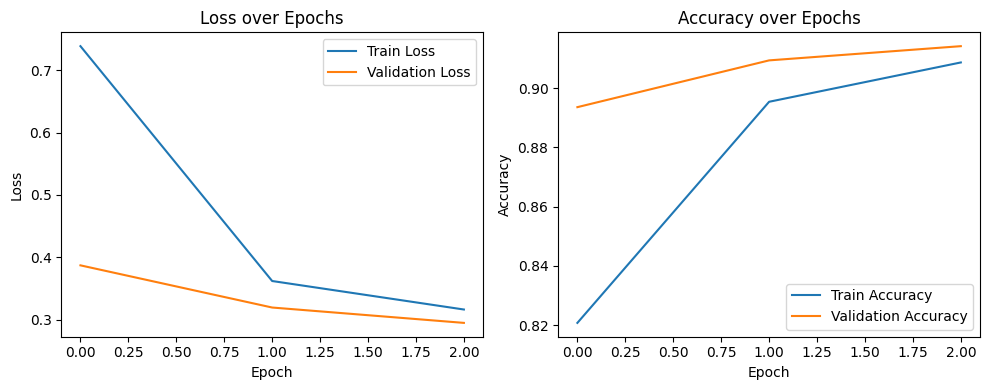

In [23]:
import matplotlib.pyplot as plt

# Loss 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()